<a href="https://colab.research.google.com/github/JTStephens18/instant_ngp_test/blob/main/InstantNGP_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt update && apt install build-essential git python3-dev python3-pip libopenexr-dev libxi-dev libglfw3-dev libglew-dev libomp-dev libxinerama-dev libxcursor-dev colmap ffmpeg jq
!pip install --upgrade cmake

Find the compute capability of the GPU in your local machine in the following link: https://developer.nvidia.com/cuda-gpus

You need this to be able to open your trained models in testbed inside your local machine later on, so you can explore them or trace a camera path in order to generate a video from your scene.

In [ ]:
compute_capability = "61" #@param [50, 52, 60, 61, 70, 72, 75, 80, 86, 87]
%env TCNN_CUDA_ARCHITECTURES=$compute_capability

For compatibility between the model trained here and the local machine, a network with FP32 or FP16 is chosen.

https://docs.nvidia.com/deeplearning/tensorrt/support-matrix/index.html#hardware-precision-matrix

In [ ]:
network_type = "FullyFusedMLP" if int(compute_capability) >= 70 else "CutlassMLP"
print(f"Using {network_type}")
%env NN_CONFIG_PATH = ./configs/nerf/base.json
!jq '.network.otype = "CutlassMLP" | .rgb_network.otype = "CutlassMLP"' NN_CONFIG_PATH

Build the project and install python requirements

In [ ]:
!cmake . -B build -DNGP_BUILD_WITH_GUI=OFF

In [ ]:
import os
scene_path = "/content/drive/MyDrive/nerf_scenes/fox" #@param {type:"string"}
if not os.path.isdir(scene_path):
  raise NotADirectoryError(scene_path)

In [ ]:
train_steps = 2000  #@param {type:"integer"}
snapshot_path = os.path.join(scene_path, f"{train_steps}.ingp")
!python ./scripts/run.py {scene_path} --n_steps {train_steps} --save_snapshot {snapshot_path}

# From Scratch

In [1]:
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
from PIL import Image
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class NGP(torch.nn.Module):

    def __init__(self, T, Nl, L, device, aabb_scale, F=2):
        super(NGP, self).__init__()
        self.T = T
        self.Nl = Nl
        self.F = F
        self.L = L  # For encoding directions
        self.aabb_scale = aabb_scale
        self.lookup_tables = torch.nn.ParameterDict(
            {str(i): torch.nn.Parameter((torch.rand(
                (T, 2), device=device) * 2 - 1) * 1e-4) for i in range(len(Nl))})
        self.pi1, self.pi2, self.pi3 = 1, 2_654_435_761, 805_459_861
        self.density_MLP = nn.Sequential(nn.Linear(self.F * len(Nl), 64),
                                         nn.ReLU(), nn.Linear(64, 16)).to(device)
        self.color_MLP = nn.Sequential(nn.Linear(27 + 16, 64), nn.ReLU(),
                                       nn.Linear(64, 64), nn.ReLU(),
                                       nn.Linear(64, 3), nn.Sigmoid()).to(device)

    def positional_encoding(self, x):
        out = [x]
        for j in range(self.L):
            out.append(torch.sin(2 ** j * x))
            out.append(torch.cos(2 ** j * x))
        return torch.cat(out, dim=1)

    def forward(self, x, d):

        x /= self.aabb_scale
        mask = (x[:, 0].abs() < .5) & (x[:, 1].abs() < .5) & (x[:, 2].abs() < .5)
        x += 0.5  # x in [0, 1]^3

        color = torch.zeros((x.shape[0], 3), device=x.device)
        log_sigma = torch.zeros((x.shape[0]), device=x.device) - 100000
        features = torch.empty((x[mask].shape[0], self.F * len(self.Nl)), device=x.device)
        for i, N in enumerate(self.Nl):
            # Computing vertices, use nn.functional.grid_sample convention
            floor = torch.floor(x[mask] * N)
            ceil = torch.ceil(x[mask] * N)
            vertices = torch.zeros((x[mask].shape[0], 8, 3), dtype=torch.int64, device=x.device)
            vertices[:, 0] = floor
            vertices[:, 1] = torch.cat((ceil[:, 0, None], floor[:, 1, None], floor[:, 2, None]), dim=1)
            vertices[:, 2] = torch.cat((floor[:, 0, None], ceil[:, 1, None], floor[:, 2, None]), dim=1)
            vertices[:, 4] = torch.cat((floor[:, 0, None], floor[:, 1, None], ceil[:, 2, None]), dim=1)
            vertices[:, 6] = torch.cat((floor[:, 0, None], ceil[:, 1, None], ceil[:, 2, None]), dim=1)
            vertices[:, 5] = torch.cat((ceil[:, 0, None], floor[:, 1, None], ceil[:, 2, None]), dim=1)
            vertices[:, 3] = torch.cat((ceil[:, 0, None], ceil[:, 1, None], floor[:, 2, None]), dim=1)
            vertices[:, 7] = ceil

            # hashing
            a = vertices[:, :, 0] * self.pi1
            b = vertices[:, :, 1] * self.pi2
            c = vertices[:, :, 2] * self.pi3
            h_x = torch.remainder(torch.bitwise_xor(torch.bitwise_xor(a, b), c), self.T)

            # Lookup
            looked_up = self.lookup_tables[str(i)][h_x].transpose(-1, -2)
            volume = looked_up.reshape((looked_up.shape[0], 2, 2, 2, 2))
            features[:, i*2:(i+1)*2] = torch.nn.functional.grid_sample(
                volume,
                ((x[mask] * N - floor) - 0.5).unsqueeze(1).unsqueeze(1).unsqueeze(1)
                ).squeeze(-1).squeeze(-1).squeeze(-1)

        xi = self.positional_encoding(d[mask])
        h = self.density_MLP(features)
        log_sigma[mask] = h[:, 0]
        color[mask] = self.color_MLP(torch.cat((h, xi), dim=1))
        return color, torch.exp(log_sigma)

In [4]:
def compute_accumulated_transmittance(alphas):
    accumulated_transmittance = torch.cumprod(alphas, 1)
    return torch.cat((torch.ones((accumulated_transmittance.shape[0], 1), device=alphas.device),
                      accumulated_transmittance[:, :-1]), dim=-1)

In [5]:
def render_rays(nerf_model, ray_origins, ray_directions, hn=0, hf=0.5, nb_bins=192):
    device = ray_origins.device
    t = torch.linspace(hn, hf, nb_bins, device=device).expand(ray_origins.shape[0], nb_bins)
    # t = t.unsqueeze(-1).unsqueeze(-1).expand(ray_origins.shape[0], nb_bins, ray_origins.shape[2], ray_origins.shape[3])
    # Perturb sampling along each ray.
    mid = (t[:, :-1] + t[:, 1:]) / 2.
    lower = torch.cat((t[:, :1], mid), -1)
    upper = torch.cat((mid, t[:, -1:]), -1)
    u = torch.rand(t.shape, device=device)
    t = lower + (upper - lower) * u  # [batch_size, nb_bins]
    delta = torch.cat((t[:, 1:] - t[:, :-1], torch.tensor(
        [1e10], device=device).expand(ray_origins.shape[0], 1)), -1)


    #     # Perturb sampling along each ray.
    # mid = (t[:, :-1, :, :] + t[:, 1:, :, :]) / 2.0
    # lower = torch.cat((t[:, :1, :, :], mid), 1)
    # upper = torch.cat((mid, t[:, -1:, :, :]), 1)
    # u = torch.rand(t.shape, device=device)
    # t = lower + (upper - lower) * u  # [batch_size, nb_bins, height, width]

    # delta = torch.cat((t[:, 1:, :, :] - t[:, :-1, :, :], torch.tensor([1e10], device=device).expand(ray_origins.shape[0], 1, ray_origins.shape[2], ray_origins.shape[3])), 1)

    # print("\n")
    # print("ray origins", ray_origins.shape)
    # print("ray origins unsqueeze", ray_origins.unsqueeze(1).shape)
    # print("t", t.shape)
    # print("t unsqueeze", t.unsqueeze(2).shape)
    # print("ray direction shape", ray_directions.shape)
    # print("ray direction unsqueeze", ray_directions.unsqueeze(1).shape)

    # Compute the 3D points along each ray
    x = ray_origins.unsqueeze(1) + t.unsqueeze(2) * ray_directions.unsqueeze(1)
    # Expand the ray_directions tensor to match the shape of x
    ray_directions = ray_directions.expand(nb_bins, ray_directions.shape[0], 3).transpose(0, 1)
    colors, sigma = nerf_model(x.reshape(-1, 3), ray_directions.reshape(-1, 3))
    alpha = 1 - torch.exp(-sigma.reshape(x.shape[:-1]) * delta)  # [batch_size, nb_bins]
    weights = compute_accumulated_transmittance(1 - alpha).unsqueeze(2) * alpha.unsqueeze(2)
    c = (weights * colors.reshape(x.shape)).sum(dim=1)
    weight_sum = weights.sum(-1).sum(-1)  # Regularization for white background
    return c + 1 - weight_sum.unsqueeze(-1)

In [6]:
@torch.no_grad()
def test(hn, hf, dataset, img_index, chunk_size=20, nb_bins=192, H=400, W=400):
    ray_origins = dataset[img_index * H * W: (img_index + 1) * H * W, :3]
    ray_directions = dataset[img_index * H * W: (img_index + 1) * H * W, 3:6]

    px_values = []   # list of regenerated pixel values
    for i in range(int(np.ceil(H / chunk_size))):   # iterate over chunks
        ray_origins_ = ray_origins[i * W * chunk_size: (i + 1) * W * chunk_size].to(device)
        ray_directions_ = ray_directions[i * W * chunk_size: (i + 1) * W * chunk_size].to(device)
        px_values.append(render_rays(model, ray_origins_, ray_directions_,
                                     hn=hn, hf=hf, nb_bins=nb_bins))
    img = torch.cat(px_values).data.cpu().numpy().reshape(H, W, 3)
    img = (img.clip(0, 1)*255.).astype(np.uint8)
    img = Image.fromarray(img)
    img.save(f'novel_views/img_{img_index}.png')

In [24]:
def train(nerf_model, optimizer, data_loader, device='cpu', hn=0, hf=1, nb_epochs=10,
          nb_bins=192, H=400, W=400):
    for ep in range(nb_epochs):
        print("Epoch: ", ep)
        idx = 0
        for batch in tqdm(data_loader):
            ray_origins = batch[:, :3].to(device)
            ray_directions = batch[:, 3:6].to(device)
            gt_px_values = batch[:, 6:].to(device)
            pred_px_values = render_rays(nerf_model, ray_origins, ray_directions,
                                         hn=hn, hf=hf, nb_bins=nb_bins)
            loss = ((gt_px_values - pred_px_values) ** 2).mean()
            if(torch.isnan(gt_px_values).any().item()):
              print("Any NaN in gt_px_values:", torch.isnan(gt_px_values).any().item())
            if (torch.isnan(pred_px_values).any().item()):
              print("Any NaN in pred_px_values:", torch.isnan(pred_px_values).any().item())
            if (idx == 0):
              print("\n loss", loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx = idx + 1

In [8]:
class TensorDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        return x

In [25]:
# training_dataset = torch.from_numpy(np.load('training_data_800x800.pkl',
#                                             allow_pickle=True))

epochs = 100

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
])

# Path to the image folder
image_folder_path = '/content/drive/MyDrive/text2scene'

images_in_dir = os.listdir(f'{image_folder_path}/Statue')
images_arr = []
for i in range(len(images_in_dir)):
  new_img = transform(Image.open(f'{image_folder_path}/Statue/{images_in_dir[i]}'))
  images_arr.append(new_img)

images_tensor = torch.stack(images_arr).to(device)

scene_rays_d, scene_rays_o = calculate_rays()

rays_tensor = torch.cat((scene_rays_o, scene_rays_d), dim=1)

dataset_tensor = torch.cat((rays_tensor, images_tensor), dim=1).reshape(-1, 9)

# *** Train / test split ***

num_batches = dataset_tensor.shape[0]

# Calculate split index
split_index = int(0.7 * num_batches)

# Shuffle the tensor
indices = torch.randperm(num_batches)

# Split the tensor
train_indices = indices[:split_index]
test_indices = indices[split_index:]

train_tensor = dataset_tensor[train_indices]
test_tensor = dataset_tensor[test_indices]

training_dataset = TensorDataset(train_tensor)

testing_dataset = TensorDataset(test_tensor)

L = 16
F = 2
T = 2**19
N_min = 16
N_max = 2048
b = np.exp((np.log(N_max) - np.log(N_min)) / (L - 1))
Nl = [int(np.floor(N_min * b**l)) for l in range(L)]
model = NGP(T, Nl, 4, device, 3)
model_optimizer = torch.optim.Adam(
    [{"params": model.lookup_tables.parameters(), "lr": 1e-2, "betas": (0.9, 0.99), "eps": 1e-15, "weight_decay": 0.},
      {"params": model.density_MLP.parameters(), "lr": 1e-2,  "betas": (0.9, 0.99), "eps": 1e-15, "weight_decay": 10**-6},
      {"params": model.color_MLP.parameters(), "lr": 1e-2,  "betas": (0.9, 0.99), "eps": 1e-15, "weight_decay": 10**-6}])
data_loader = DataLoader(training_dataset, batch_size=2**14, shuffle=True)

train(model, model_optimizer, data_loader, nb_epochs=epochs, device=device,
      hn=2, hf=6, nb_bins=192, H=images_tensor.shape[2], W=images_tensor.shape[3])
for img_index in range(29):
    test(2, 6, testing_dataset, img_index, nb_bins=192, H=images_tensor.shape[2], W=images_tensor.shape[3])

num_cam 1
num_reg_images 29
Epoch:  0


  0%|          | 1/237 [00:00<03:22,  1.17it/s]


 loss 2.4541831016540527


100%|██████████| 237/237 [03:50<00:00,  1.03it/s]


Epoch:  1


  0%|          | 1/237 [00:00<03:25,  1.15it/s]


 loss 2.1707324981689453


100%|██████████| 237/237 [03:50<00:00,  1.03it/s]


Epoch:  2


  0%|          | 1/237 [00:00<03:31,  1.12it/s]


 loss 2.2718238830566406


100%|██████████| 237/237 [03:50<00:00,  1.03it/s]


Epoch:  3


  0%|          | 1/237 [00:00<03:54,  1.01it/s]


 loss 2.3157010078430176


100%|██████████| 237/237 [03:50<00:00,  1.03it/s]


Epoch:  4


  0%|          | 1/237 [00:00<03:14,  1.21it/s]


 loss 2.1664304733276367


100%|██████████| 237/237 [03:50<00:00,  1.03it/s]


Epoch:  5


  0%|          | 1/237 [00:00<03:21,  1.17it/s]


 loss 2.234699010848999


100%|██████████| 237/237 [03:49<00:00,  1.03it/s]


Epoch:  6


  0%|          | 1/237 [00:00<03:14,  1.21it/s]


 loss 2.168854236602783


100%|██████████| 237/237 [03:49<00:00,  1.03it/s]


Epoch:  7


  0%|          | 1/237 [00:00<03:17,  1.20it/s]


 loss 2.127594470977783


100%|██████████| 237/237 [03:50<00:00,  1.03it/s]


Epoch:  8


  0%|          | 1/237 [00:00<03:51,  1.02it/s]


 loss 2.223060369491577


100%|██████████| 237/237 [03:50<00:00,  1.03it/s]


Epoch:  9


  0%|          | 1/237 [00:00<03:32,  1.11it/s]


 loss 2.2557880878448486


100%|██████████| 237/237 [03:50<00:00,  1.03it/s]


Epoch:  10


  0%|          | 1/237 [00:00<03:18,  1.19it/s]


 loss 2.310401678085327


100%|██████████| 237/237 [03:49<00:00,  1.03it/s]


Epoch:  11


  0%|          | 1/237 [00:00<03:20,  1.17it/s]


 loss 2.193075656890869


100%|██████████| 237/237 [03:49<00:00,  1.03it/s]


Epoch:  12


  0%|          | 1/237 [00:00<03:18,  1.19it/s]


 loss 2.163113594055176


100%|██████████| 237/237 [03:49<00:00,  1.03it/s]


Epoch:  13


  0%|          | 1/237 [00:00<03:21,  1.17it/s]


 loss 2.2080209255218506


100%|██████████| 237/237 [03:50<00:00,  1.03it/s]


Epoch:  14


  0%|          | 1/237 [00:01<04:24,  1.12s/it]


 loss 2.2588791847229004


100%|██████████| 237/237 [03:50<00:00,  1.03it/s]


Epoch:  15


  0%|          | 1/237 [00:01<04:40,  1.19s/it]


 loss 2.0992937088012695


100%|██████████| 237/237 [03:50<00:00,  1.03it/s]


Epoch:  16


  0%|          | 1/237 [00:01<04:13,  1.08s/it]


 loss 2.1618616580963135


100%|██████████| 237/237 [03:50<00:00,  1.03it/s]


Epoch:  17


  0%|          | 1/237 [00:01<04:10,  1.06s/it]


 loss 2.181800365447998


100%|██████████| 237/237 [03:50<00:00,  1.03it/s]


Epoch:  18


  0%|          | 1/237 [00:00<03:28,  1.13it/s]


 loss 2.226963758468628


100%|██████████| 237/237 [03:50<00:00,  1.03it/s]


Epoch:  19


  0%|          | 1/237 [00:00<03:33,  1.11it/s]


 loss 2.2067034244537354


100%|██████████| 237/237 [03:50<00:00,  1.03it/s]


Epoch:  20


  0%|          | 1/237 [00:01<03:57,  1.01s/it]


 loss 2.2155113220214844


100%|██████████| 237/237 [03:50<00:00,  1.03it/s]


Epoch:  21


  0%|          | 1/237 [00:00<03:24,  1.15it/s]


 loss 2.2220065593719482


100%|██████████| 237/237 [03:50<00:00,  1.03it/s]


Epoch:  22


  0%|          | 1/237 [00:00<03:30,  1.12it/s]


 loss 2.282059907913208


100%|██████████| 237/237 [03:50<00:00,  1.03it/s]


Epoch:  23


  0%|          | 1/237 [00:01<04:05,  1.04s/it]


 loss 2.21530818939209


  5%|▍         | 11/237 [00:11<03:51,  1.03s/it]


KeyboardInterrupt: 

In [ ]:
for img_index in range(29):
    test(2, 6, testing_dataset, img_index, nb_bins=192, H=images_tensor.shape[2], W=images_tensor.shape[3])

<ipython-input-52-723822c24442>:13: RuntimeWarning: invalid value encountered in cast
  img = (img.clip(0, 1)*255.).astype(np.uint8)


ValueError: cannot reshape array of size 400077 into shape (378,504,3)

In [26]:
print(dataset_tensor.shape)
print(rays_tensor.shape)
print(images_tensor.shape)
print(num_batches)
print(scene_rays_o.shape)

torch.Size([5524848, 9])
torch.Size([29, 6, 378, 504])
torch.Size([29, 3, 378, 504])
5524848
torch.Size([29, 3, 378, 504])


In [31]:
ray_o = scene_rays_o[0].reshape(-1, 3)
print(ray_o.shape)
ray_d = scene_rays_d[0].reshape(-1, 3)
print(ray_d.shape)

torch.Size([190512, 3])
torch.Size([190512, 3])


In [33]:
pred_px_values = render_rays(model, ray_o, ray_d,
                              hn=2, hf=6, nb_bins=192,)

OutOfMemoryError: CUDA out of memory. Tried to allocate 802.00 MiB. GPU 

In [ ]:

num_batches = dataset_tensor.shape[0]

# Calculate split index
split_index = int(0.7 * num_batches)

# Shuffle the tensor
indices = torch.randperm(num_batches)

# Split the tensor
train_indices = indices[:split_index]
test_indices = indices[split_index:]

train_tensor = dataset_tensor[train_indices]
test_tensor = dataset_tensor[test_indices]


torch.Size([3867393, 9])
torch.Size([1657455, 9])
5524848
5524848


In [9]:
import collections
import struct

def read_next_bytes(fid, num_bytes, format_char_sequence, endian_character="<"):
    """Read and unpack the next bytes from a binary file.
    :param fid:
    :param num_bytes: Sum of combination of {2, 4, 8}, e.g. 2, 6, 16, 30, etc.
    :param format_char_sequence: List of {c, e, f, d, h, H, i, I, l, L, q, Q}.
    :param endian_character: Any of {@, =, <, >, !}
    :return: Tuple of read and unpacked values.
    """
    data = fid.read(num_bytes)
    return struct.unpack(endian_character + format_char_sequence, data)


def read_cameras_binary(path):
  cameras = []
  camObj = {}
  with open(path, 'rb') as fid:
    num_cam = read_next_bytes(fid, 8, "Q")[0]
    print("num_cam", num_cam)
    for _ in range(num_cam):
      cam_prop = read_next_bytes(fid, num_bytes=24, format_char_sequence="iiQQ")
      cam_id = cam_prop[0]
      # print("camera id", cam_id)
      # print("model prop", cam_prop[1])
      # print("width prop", cam_prop[2])
      # print("height prop", cam_prop[3])
      num_params = 4
      params = read_next_bytes(fid, num_bytes=8 * num_params, format_char_sequence="d" * num_params)
      # print("params", params)
      cameras.append({
          "id": cam_id,
          "width": cam_prop[2],
          "height": cam_prop[3],
          "params": torch.tensor(params)
      })

      camObj[cam_id] = {
          "id": cam_id,
          "width": cam_prop[2],
          "height": cam_prop[3],
          "params": np.array(params)
      }

  return cameras, num_cam, camObj


cam_intrinsic, num_cameras, camObj = read_cameras_binary("/content/cameras.bin")

num_cam 1


In [13]:
def read_images_binary(path_to_model_file):
    """
    see: src/colmap/scene/reconstruction.cc
        void Reconstruction::ReadImagesBinary(const std::string& path)
        void Reconstruction::WriteImagesBinary(const std::string& path)
    """
    images = {}
    imgArr = []
    with open(path_to_model_file, "rb") as fid:
        num_reg_images = read_next_bytes(fid, 8, "Q")[0]
        print("num_reg_images", num_reg_images)
        for _ in range(num_reg_images):
            binary_image_properties = read_next_bytes(
                fid, num_bytes=64, format_char_sequence="idddddddi"
            )
            image_id = binary_image_properties[0]
            qvec = np.array(binary_image_properties[1:5])
            tvec = np.array(binary_image_properties[5:8])
            camera_id = binary_image_properties[8]
            binary_image_name = b""
            current_char = read_next_bytes(fid, 1, "c")[0]
            while current_char != b"\x00":  # look for the ASCII 0 entry
                binary_image_name += current_char
                current_char = read_next_bytes(fid, 1, "c")[0]
            image_name = binary_image_name.decode("utf-8")
            num_points2D = read_next_bytes(
                fid, num_bytes=8, format_char_sequence="Q"
            )[0]
            x_y_id_s = read_next_bytes(
                fid,
                num_bytes=24 * num_points2D,
                format_char_sequence="ddq" * num_points2D,
            )
            xys = np.column_stack(
                [
                    tuple(map(float, x_y_id_s[0::3])),
                    tuple(map(float, x_y_id_s[1::3])),
                ]
            )
            point3D_ids = np.array(tuple(map(int, x_y_id_s[2::3])))
            images[image_id] = {
                "id": image_id,
                "qvec": qvec,
                "tvec": tvec,
                "camera_id": camera_id,
                "name": image_name,
                "xys": xys,
                "point3D_ids": point3D_ids
            }
            imgArr.append({
                "id": image_id,
                "qvec": qvec,
                "tvec": tvec,
                "camera_id": camera_id,
                "name": image_name,
                "xys": xys,
                "point3D_ids": point3D_ids
            })
    return images, imgArr

ce, cam_extrinsic = read_images_binary("/content/images.bin")

num_reg_images 29


In [10]:
def qvec2rotmat(qvec):
  return np.array([
    [1 - 2 * qvec[2]**2 - 2 * qvec[3]**2,
      2 * qvec[1] * qvec[2] - 2 * qvec[0] * qvec[3],
      2 * qvec[3] * qvec[1] + 2 * qvec[0] * qvec[2]],
    [2 * qvec[1] * qvec[2] + 2 * qvec[0] * qvec[3],
      1 - 2 * qvec[1]**2 - 2 * qvec[3]**2,
      2 * qvec[2] * qvec[3] - 2 * qvec[0] * qvec[1]],
    [2 * qvec[3] * qvec[1] - 2 * qvec[0] * qvec[2],
      2 * qvec[2] * qvec[3] + 2 * qvec[0] * qvec[1],
      1 - 2 * qvec[1]**2 - 2 * qvec[2]**2]
  ])



def getCamera2World(R, t, translate=torch.tensor([0.0, 0.0, 0.0]).to(device), scale=1.0):
  Rt = torch.zeros(R.shape[0], 4, 4).to(device)
  Rt[:, :3, :3] = R.transpose(2, 1)
  Rt[:, :3, 3] = t
  Rt[:, 3, 3] = 1.0

  C2W = torch.inverse(Rt)
  cam_center = C2W[:, :3, 3]
  cam_center = (cam_center + translate) * scale
  C2W[:, :3, 3] = cam_center
  return C2W

In [11]:
def createC2WMatrix(cam_extrinsic, cam_intrinsic):
  rotArr = []
  tArr = []

  for idx, key in enumerate(cam_extrinsic):
    extr = cam_extrinsic[idx]
    # print(extr['camera_id'])
    # intr = cam_intrinsic[extr['camera_id']]

    intr = next((obj for obj in cam_intrinsic if obj['id'] == extr['camera_id']))

    rot = torch.tensor(qvec2rotmat(extr['qvec'])).to(device)
  # Transpose
    rot = rot.permute(1,0)
    rotArr.append(rot)
    t = torch.tensor(extr['tvec']).to(device)
    tArr.append(t)


  rotTensor = torch.stack(rotArr, dim=0)
  tTensor = torch.stack(tArr, dim=0)
  C2W = getCamera2World(rotTensor, tTensor)
  return C2W

In [12]:
def calculate_rays():
  cam_intrinsic, num_cameras, camObj = read_cameras_binary("/content/cameras.bin")
  ce, cam_extrinsic = read_images_binary("/content/images.bin")

  C2W = createC2WMatrix(cam_extrinsic, cam_intrinsic)

  W = images_tensor.shape[2]
  H = images_tensor.shape[3]

  view_idx = 0

  scene_rays_d = torch.zeros((C2W.shape[0], W, H, 3)).to(device)
  scene_rays_o = torch.zeros((C2W.shape[0], W, H, 3)).to(device)

  for view_idx in range(C2W.shape[0]):

    focal_length = cam_intrinsic[0]['params'][0]

    u, v = torch.meshgrid(torch.arange(W), torch.arange(H))
    dirs = torch.stack((v - W / 2, -(u - H / 2.), - torch.ones_like(u) * focal_length), axis=-1).to(device)
    dirs = (C2W[view_idx, :3, :3] @ dirs[..., None]).squeeze(-1)

    scene_rays_d[view_idx] = dirs / torch.linalg.norm(dirs, axis=-1, keepdims=True)
    scene_rays_o[view_idx] = torch.zeros_like(scene_rays_d[view_idx]) + C2W[view_idx, :3, 3]

  return scene_rays_d.permute(0, 3, 1, 2), scene_rays_o.permute(0, 3, 1, 2)

In [ ]:
W = images_tensor.shape[2]
H = images_tensor.shape[3]

view_idx = 0

scene_rays_d = torch.zeros((C2W.shape[0], W, H, 3))
scene_rays_o = torch.zeros((C2W.shape[0], W, H, 3))

u, v = torch.meshgrid(torch.arange(W), torch.arange(H))
dirs = torch.stack((v - W / 2, -(u - H / 2.), - torch.ones_like(u) * focal_length), axis=-1)
dirs = (C2W[view_idx, :3, :3] @ dirs[..., None]).squeeze(-1)

scene_rays_d[view_idx] = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True)
scene_rays_o[view_idx] = torch.zeros_like(scene_rays_d[view_idx]) + C2W[view_idx, :3, 3]

/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

idx 0 direction tensor([[[-0.0624,  0.2761, -0.9591],
         [-0.0611,  0.2761, -0.9592],
         [-0.0598,  0.2761, -0.9593],
         ...,
         [ 0.2678,  0.2598, -0.9278],
         [ 0.2691,  0.2597, -0.9274],
         [ 0.2703,  0.2596, -0.9271]],

        [[-0.0624,  0.2748, -0.9595],
         [-0.0611,  0.2748, -0.9596],
         [-0.0598,  0.2748, -0.9596],
         ...,
         [ 0.2678,  0.2586, -0.9281],
         [ 0.2691,  0.2585, -0.9278],
         [ 0.2703,  0.2583, -0.9275]],

        [[-0.0625,  0.2736, -0.9598],
         [-0.0612,  0.2736, -0.9599],
         [-0.0599,  0.2736, -0.9600],
         ...,
         [ 0.2679,  0.2573, -0.9285],
         [ 0.2691,  0.2572, -0.9281],
         [ 0.2703,  0.2571, -0.9278]],

        ...,

        [[-0.0753, -0.0537, -0.9957],
         [-0.0740, -0.0538, -0.9958],
         [-0.0727, -0.0539, -0.9959],
         ...,
         [ 0.2551, -0.0702, -0.9644],
         [ 0.2563, -0.0702, -0.9640],
         [ 0.2576, -0.0703, -0.963

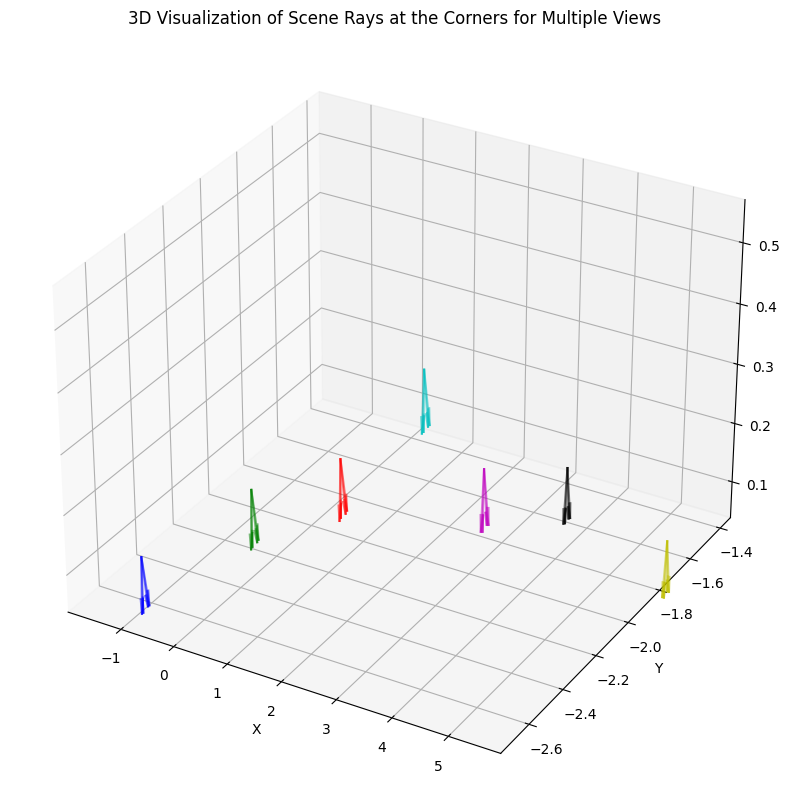

In [ ]:
def plot_rays(view_indices, scene_rays_o, scene_rays_d):

  view_indices = [0, 1, 2, 3, 4, 5, 6]  # List of view indices to visualize

  W = scene_rays_o.shape[2]
  H = scene_rays_o.shape[3]

  # # Compute scene_rays_d and scene_rays_o for all views
  # scene_rays_d = torch.zeros((C2W.shape[0], W, H, 3))
  # scene_rays_o = torch.zeros((C2W.shape[0], W, H, 3))

  # u, v = torch.meshgrid(torch.arange(W), torch.arange(H), indexing='ij')
  # dirs = torch.stack((v - W / 2, -(u - H / 2.), - torch.ones_like(u) * focal_length), axis=-1)

  # for view_idx in range(C2W.shape[0]):
  #     dirs_transformed = (C2W[view_idx, :3, :3] @ dirs[..., None]).squeeze(-1)
  #     scene_rays_d[view_idx] = dirs_transformed / torch.norm(dirs_transformed, dim=-1, keepdim=True)
  #     scene_rays_o[view_idx] = torch.zeros_like(scene_rays_d[view_idx]) + C2W[view_idx, :3, 3]

  # Select the four corners
  corner_indices = [(0, 0), (0, W-1), (H-1, 0), (H-1, W-1)]

  # Create a 3D plot to visualize the rays at the corners for multiple views
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(111, projection='3d')

  colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Different colors for different views

  for i, view_idx in enumerate(view_indices):
      origins = [scene_rays_o[view_idx, w, h].numpy() for w, h in corner_indices]
      directions = [scene_rays_d[view_idx, w, h].numpy() for w, h in corner_indices]

      # Plot rays for the current view
      for origin, direction in zip(origins, directions):
          ax.quiver(
              origin[0], origin[1], origin[2],
              direction[0], direction[1], direction[2],
              length=0.1, normalize=True, color=colors[i % len(colors)], alpha=0.5
          )

  # Set labels and title
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  ax.set_title('3D Visualization of Scene Rays at the Corners for Multiple Views')

  # Show plot
  plt.show()

# HiFA

In [ ]:
!git clone https://github.com/JunzheJosephZhu/HiFA.git

Cloning into 'HiFA'...
remote: Enumerating objects: 339, done.
remote: Counting objects: 100% (339/339), done.
remote: Compressing objects: 100% (252/252), done.
remote: Total 339 (delta 87), reused 278 (delta 47), pack-reused 0
Receiving objects: 100% (339/339), 21.57 MiB | 17.09 MiB/s, done.
Resolving deltas: 100% (87/87), done.


In [ ]:
!pip install -r ./HiFA/requirements.txt

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117
  Cloning https://github.com/NVlabs/nvdiffrast to /tmp/pip-req-build-dd10s19z
  Running command git clone --filter=blob:none --quiet https://github.com/NVlabs/nvdiffrast /tmp/pip-req-build-dd10s19z
  Resolved https://github.com/NVlabs/nvdiffrast to commit c5caf7bdb8a2448acc491a9faa47753972edd380
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 799.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 694.7/694.7 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.3/274.3 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 35.2 MB/s eta 0:00:00
    

In [ ]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu117.html

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu117.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 19.0 MB/s eta 0:00:00


In [ ]:
!pip install "jax[cuda12_pip]==0.4.23" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.8/131.8 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.3/363.3 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.5/22.5 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 895.7/895.7 kB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.3/130.3 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.6/217.6 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [ ]:
! python ./HiFA/main1.py --text "a baby bunny sitting on top of a stack of pancakes" --workspace trials_throne_sanity --dir_text --albedo --phi_range 0 120

2024-07-02 14:54:17.364916: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-02 14:54:17.364971: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-02 14:54:17.366202: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-02 14:54:18.557187: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid